In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import ipywidgets
import jupyterlab_widgets
from tqdm.auto import tqdm
# Ignore Warnings
import warnings
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random 

In [2]:
!pip install pandas matplotlib Pillow tqdm scikit-learn torch torchvision
!pip install pandas-path
!pip install torchsummary
from pandas_path import path

In [3]:
import copy
from pathlib import Path
from pprint import pprint
import pandas as pd

In [4]:
DATA_PATH =Path.cwd().parent / "/kaggle/input/hackaton-train/train"

In [5]:
list(os.listdir(DATA_PATH))

['images', 'train.csv']

In [6]:
train = pd.read_csv(DATA_PATH/"train.csv", index_col="image_id")

In [7]:
train.head()

,filename,label
image_id,,
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0
5,5.jpg,0


<Axes: ylabel='count'>

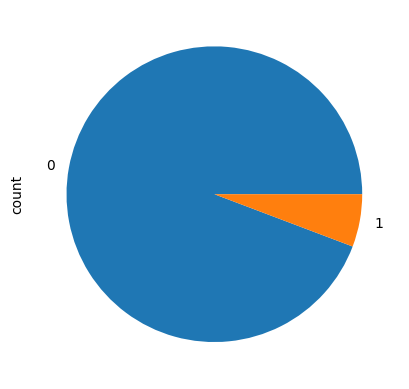

In [8]:
train["label"].value_counts().plot(kind="pie")

Imbalanced Dataset

In [9]:
x=train.filename.to_frame()
y=train.label.to_frame()

In [10]:
random.seed(7)

In [11]:
x_train1, x_eval, y_train1, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.20
)

In [12]:
x_train, x_tst, y_train, y_tst = train_test_split(
    x_train1, y_train1, stratify=y_train1, test_size=0.10
)

In [13]:
x_train.head(),x_eval.head(),x_tst.head()

(          filename
 image_id          
 937        937.jpg
 5109      5109.jpg
 1490      1490.jpg
 861        861.jpg
 1360      1360.jpg,
           filename
 image_id          
 6077      6077.jpg
 510        510.jpg
 1783      1783.jpg
 6236      6236.jpg
 4835      4835.jpg,
           filename
 image_id          
 4705      4705.jpg
 958        958.jpg
 5597      5597.jpg
 5733      5733.jpg
 1502      1502.jpg)

In [14]:
y_train.head(),y_eval.head(),y_tst.head()

(          label
 image_id       
 937           0
 5109          0
 1490          0
 861           0
 1360          0,
           label
 image_id       
 6077          0
 510           0
 1783          0
 6236          0
 4835          0,
           label
 image_id       
 4705          0
 958           0
 5597          0
 5733          0
 1502          0)

In [15]:
y_train.value_counts(),y_eval.value_counts(),y_tst.value_counts()

(label
 0        5481
 1         335
 Name: count, dtype: int64,
 label
 0        1523
 1          93
 Name: count, dtype: int64,
 label
 0        610
 1         37
 Name: count, dtype: int64)

In [16]:
image_dir=f'{DATA_PATH}/images'

In [17]:
image_dir

'/kaggle/input/hackaton-train/train/images'

In [18]:
class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self,dir, x_df, y_df=None,transforms=None):
        self.dir=dir
        self.data = x_df
        self.label = y_df
        self.transform = transforms

    def __getitem__(self, index):
        image = Image.open(os.path.join(self.dir,self.data.iloc[index]["filename"])).convert("RGB")
        if self.transform:
            image = self.transform(image)
            image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}

        else:
            label = torch.tensor(self.label.iloc[index].values,
                                 dtype=torch.float)

            sample = {"image_id": image_id, "image": image, "label": label}


        return sample

    def __len__(self):
        return len(self.data)

In [19]:
transformations = transforms.Compose(
    [   transforms.Grayscale(num_output_channels=3),
        transforms.Resize((256,256)),
        transforms.ColorJitter(brightness=0.4,
                     contrast=0.8,
                     saturation=0.4,
                     hue=0.3),
        transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]
)

In [20]:
train_dataset = ImagesDataset(image_dir,x_train, y_train,transforms=transformations)
train_loader = DataLoader(train_dataset, batch_size=32)
eval_dataset=ImagesDataset(image_dir,x_eval,y_eval, transforms=transformations)
eval_loader=DataLoader(eval_dataset,batch_size=32)
tst_dataset=ImagesDataset(image_dir,x_tst,y_tst, transforms=transformations)
tst_loader=DataLoader(tst_dataset,batch_size=32)



In [21]:
train_dataset.label.value_counts(),eval_dataset.label.value_counts(),tst_dataset.label.value_counts()

(label
 0        5481
 1         335
 Name: count, dtype: int64,
 label
 0        1523
 1          93
 Name: count, dtype: int64,
 label
 0        610
 1         37
 Name: count, dtype: int64)

In [22]:
from PIL import Image
from torchvision.utils import make_grid

In [23]:
train_dataset[0]

{'image_id': 937,
 'image': tensor([[[-0.1143, -0.1657, -0.1657,  ...,  1.0673,  0.8961,  0.7762],
          [ 0.0056, -0.2513, -0.1486,  ...,  0.9132,  0.7248,  0.5878],
          [-0.1486, -0.1828,  0.0056,  ...,  0.9646,  0.7248,  0.5878],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -1.5357, -1.5185, -1.1247],
          [-2.1179, -2.1179, -2.1179,  ..., -1.5185, -1.5357, -1.3130],
          [-2.1179, -2.1179, -2.1179,  ..., -1.6042, -1.5014, -1.2959]],
 
         [[ 0.0126, -0.0399, -0.0399,  ...,  1.2206,  1.0455,  0.9230],
          [ 0.1352, -0.1275, -0.0224,  ...,  1.0630,  0.8704,  0.7304],
          [-0.0224, -0.0574,  0.1352,  ...,  1.1155,  0.8704,  0.7304],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -1.4405, -1.4230, -1.0203],
          [-2.0357, -2.0357, -2.0357,  ..., -1.4230, -1.4405, -1.2129],
          [-2.0357, -2.0357, -2.0357,  ..., -1.5105, -1.4055, -1.1954]],
 
         [[ 0.2348,  0.1825,  0.1825,  ...,  1.4374,  1.2631,  1.1411],
 

In [24]:
for sample in train_loader:
    print(sample['image'].shape,sample['label'])
    break

torch.Size([32, 3, 256, 256]) tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])


In [25]:
DATA_PATH_TEST =Path.cwd().parent / "/kaggle/input/hackaton-test/test"
test = pd.read_csv(DATA_PATH_TEST/"test.csv",index_col="image_id")
test.head()

,filename
image_id,
8080,8080.jpg
8081,8081.jpg
8082,8082.jpg
8083,8083.jpg
8084,8084.jpg


In [26]:
x_test=test.filename.to_frame()

In [27]:
image_test_dir=f'{DATA_PATH_TEST}/images'

In [28]:
test_dataset = ImagesDataset(image_test_dir,x_test,transforms=transformations)

In [29]:
test_loader = DataLoader(test_dataset, batch_size=32)

In [30]:
len(test_loader)

109

In [31]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for sample in dl:
        fig,ax = plt.subplots(figsize = (8,4))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(sample['image'],nrow=8).permute(1,2,0))
        break

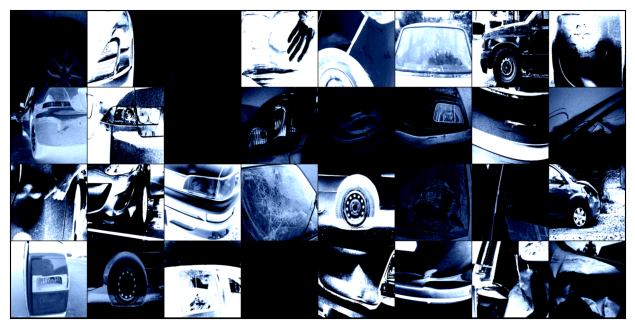

In [32]:
show_batch(train_loader)

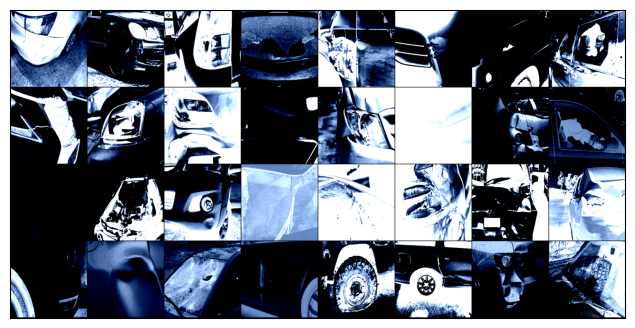

In [33]:
show_batch(test_loader)

In [34]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batch3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.2)
        self.flat = nn.Flatten()

    def forward(self, x):
        # Conv 1
        x=self.conv1(x)
        x = self.batch1(x)
        x=F.relu(x)
        # Pool 1
        x=self.pool(x)
        # Conv 2
        x = self.conv2(x)
        x = self.batch2(x)
        x=F.relu(x)
        # Pool 2
        x=self.pool(x)
        # Conv 3
        x=self.conv3(x)
        x=self.batch3(x)
        x=F.relu(x)
        # Pool 3
        x=self.pool(x)
        x=self.flat(x)
        #x = x.view(x.size(0),-1)
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# model_conv = Net()

In [35]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
model_Simple_CNN=Simple_CNN()
model_Simple_CNN.to(device)

Simple_CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [37]:
!pip install efficientnet_pytorch
from torchvision import models

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=08da51e8fee08bbccfd6a98bc343c40df795c96c177327b5c54e58c037b296e8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [38]:
import torchvision

In [39]:
model_resnet = torchvision.models.resnet50()

In [40]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
in_features=model_resnet.fc.in_features
in_features

2048

In [42]:
out_features=1

In [43]:
#let's update the pretarined model:
for param in model_resnet.parameters():
  param.requires_grad=False

In [44]:
model_resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features,
        out_features
    )
    
)

In [45]:
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
from torchsummary import summary

In [47]:
summary(model_Simple_CNN, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Flatten-10                [-1, 65536]               0
           Linear-11                  [-1, 512]      33,554,944
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
           Linear-14                   

In [48]:
summary(model_resnet,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [49]:
num_epochs=8
post_weight = torch.tensor([7.0])
post_weight.to(device)

tensor([7.], device='cuda:0')

In [50]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    pos_weight=torch.tensor([9.0])
    loss_function = nn.BCEWithLogitsLoss(pos_weight=post_weight.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None
    early_stopping_tolerance = 4
    #early_stopping_threshold = 0.003

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for batch_n,batch in tqdm(enumerate( train_dataloader),total=len(train_dataloader)):
                        batch['image'] = batch['image'].to(device)
                        batch['label'] = batch['label'].to(device)

                        optimizer.zero_grad()
                        outputs = model(batch['image'])
                        loss = loss_function(outputs, batch['label'])
                        outputs=F.sigmoid(outputs)
                        preds = (outputs>=0.5).float()
                        correct_items = (preds == batch['label']).float().sum()

                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(batch['image'])

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for batch_n,batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
                        batch['image'] = batch['image'].to(device)
                        batch['label'] = batch['label'].to(device)
                        outputs = model(batch['image'])
                        loss = loss_function(outputs, batch['label'])
                        outputs=F.sigmoid(outputs)
                        preds = (outputs>=0.5).float()
                        correct_items = (preds == batch['label']).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(batch['image'])

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

                #early stopping
                early_stopping_counter = 0
                if epoch_loss / epoch_items > lowest_val_loss:
                  early_stopping_counter +=1

                if (early_stopping_counter == early_stopping_tolerance):#or (lowest_val_loss <= early_stopping_threshold):
                  print("/nTerminating: early stopping")
                  break #terminate training



    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array


def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for Simple_CNN_1: 0.026386711838664395
Epoch: 2 | Learning rate: [0.0003]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for Simple_CNN_1: 0.025010114535689354
Epoch: 3 | Learning rate: [0.0003]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for Simple_CNN_1: 0.02495731654955019
Epoch: 4 | Learning rate: [3.267e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for Simple_CNN_1: 0.02426148366441231
Epoch: 5 | Learning rate: [9.9e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for Simple_CNN_1: 0.021371144395653564
Epoch: 6 | Learning rate: [9.9e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for Simple_CNN_1: 0.021313479216308287
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for Simple_CNN_1: 0.01946941570443387
Epoch: 8 | Learning rate: [3.267e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

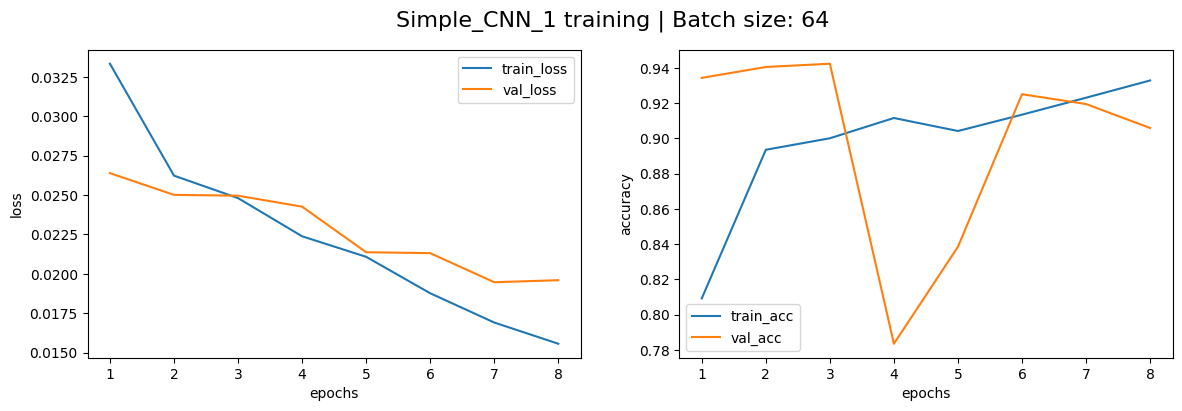


Training results:
	Min val loss 0.0195 was achieved during epoch #7
	Val accuracy during min val loss is 0.9196


In [51]:
Simple_CNN_training_results = training(model=model_Simple_CNN,
                                      model_name='Simple_CNN_1',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_loader,
                                      val_dataloader=eval_loader)

model_Simple_CNN, train_loss_array, train_acc_array, val_loss_array, val_acc_array = Simple_CNN_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="Simple_CNN_1",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [52]:
torch.save(model_Simple_CNN.state_dict(),"Simple_CNN_1")

In [53]:
ids_all = []
predictions = []
labels= []
true_labels=[]
tst_acc_array = []
epoch_correct_items = 0
epoch_items = 0
# put the model in eval mode so we don't update any parameters
model_Simple_CNN.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(tst_loader, total=len(tst_loader)):
        ids=batch["image_id"]
        batch["image"]=batch["image"].to(device)
        batch["label"]=batch["label"].to(device)
        trues=batch["label"]
        # run the forward step
        y_pred = model_Simple_CNN.forward(batch["image"])
        y_pred=F.sigmoid(y_pred)
        predictions.append(y_pred .float().cpu().numpy())
        labels.append((y_pred >= 0.5).float().cpu().numpy())
        true_labels.append(trues.float().cpu().numpy)
        preds = (y_pred>=0.5).float()
        correct_items = (preds == batch['label']).float().sum()
        epoch_correct_items += correct_items.item()
        epoch_items += len(batch['image'])
        for _id in ids:
          ids_all.append(_id.float().cpu().numpy())
    tst_acc_array.append(epoch_correct_items / epoch_items)
print("Done making predictions!")


  0%|          | 0/21 [00:00<?, ?it/s]

Done making predictions!


In [54]:
epoch_correct_items

589.0

In [55]:
tst_acc_array

[0.910355486862442]

In [56]:
pred_tst = pd.DataFrame({
    "id": ids_all,
    "prediction": np.concatenate(predictions).reshape(-1,).astype("float"),
    "label": np.concatenate(labels).reshape(-1,).astype("int"),
}).set_index("id")

pred_tst.head()

,prediction,label
id,,
4705.0,0.187366,0
958.0,0.137898,0
5597.0,0.045942,0
5733.0,0.259721,0
1502.0,0.078329,0


<Axes: ylabel='count'>

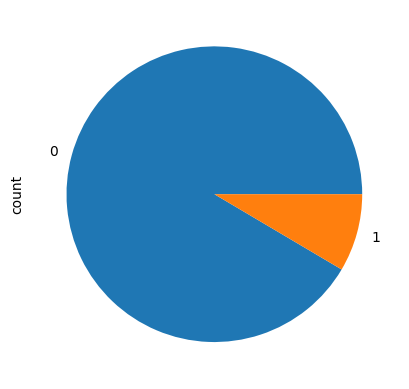

In [57]:
pred_tst["label"].value_counts().plot(kind="pie")

In [58]:
y_tst.value_counts(),pred_tst.label.value_counts()

(label
 0        610
 1         37
 Name: count, dtype: int64,
 label
 0    592
 1     55
 Name: count, dtype: int64)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for resnet: 0.025330624367931102
Epoch: 2 | Learning rate: [0.0003]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 3 | Learning rate: [0.0003]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for resnet: 0.025057196174517717
Epoch: 4 | Learning rate: [3.267e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 5 | Learning rate: [9.9e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 6 | Learning rate: [9.9e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8 | Learning rate: [3.267e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

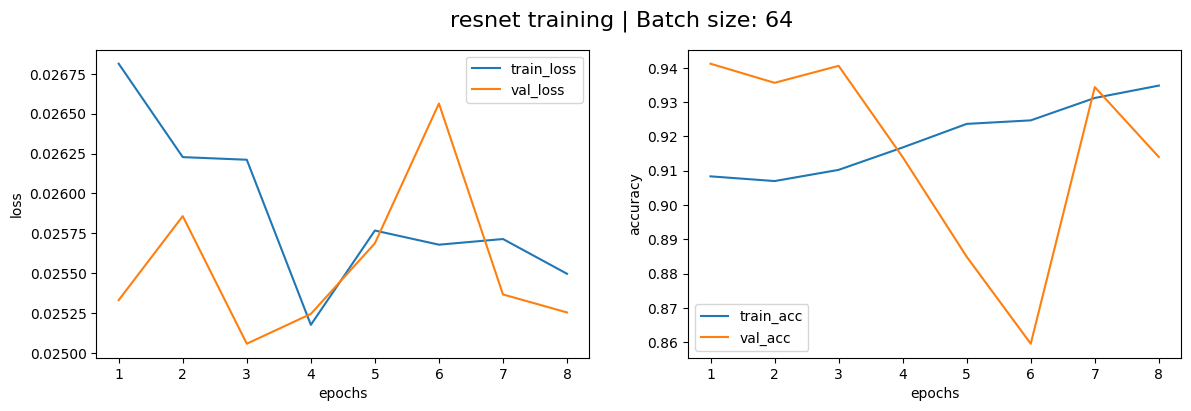


Training results:
	Min val loss 0.0251 was achieved during epoch #3
	Val accuracy during min val loss is 0.9406


In [59]:
resnet_training_results = training(model=model_resnet,
                                        model_name='resnet',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_loader,
                                        val_dataloader=eval_loader)

model_resnet, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="resnet",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [60]:
torch.save(model_resnet.state_dict(), "resnet_1.pth")

In [61]:
#model_resnet.load_state_dict(torch.load("resnet.pth"))

In [62]:
#model_resnet.to(device)

In [63]:
ids_all = []
predictions = []
labels= []
true_labels=[]
tst_acc_array = []
epoch_correct_items = 0
epoch_items = 0
# put the model in eval mode so we don't update any parameters
model_resnet.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(tst_loader, total=len(tst_loader)):
        ids=batch["image_id"]
        batch["image"]=batch["image"].to(device)
        batch["label"]=batch["label"].to(device)
        trues=batch["label"]
        # run the forward step
        y_pred = model_resnet.forward(batch["image"])
        y_pred=F.sigmoid(y_pred)
        predictions.append(y_pred .float().cpu().numpy())
        labels.append((y_pred >= 0.5).float().cpu().numpy())
        true_labels.append(trues.float().cpu().numpy)
        preds = (y_pred>=0.5).float()
        correct_items = (preds == batch['label']).float().sum()
        epoch_correct_items += correct_items.item()
        epoch_items += len(batch['image'])
        for _id in ids:
          ids_all.append(_id.float().cpu().numpy())
    tst_acc_array.append(epoch_correct_items / epoch_items)
print("Done making predictions!")

  0%|          | 0/21 [00:00<?, ?it/s]

Done making predictions!


In [64]:
epoch_correct_items

610.0

In [65]:
tst_acc_array

[0.9428129829984544]

In [66]:
pred_tst = pd.DataFrame({
    "id": ids_all,
    "prediction": np.concatenate(predictions).reshape(-1,).astype("float"),
    "label": np.concatenate(labels).reshape(-1,).astype("int"),
}).set_index("id")

In [67]:
pred_tst.head()

,prediction,label
id,,
4705.0,0.247949,0
958.0,0.251327,0
5597.0,0.255585,0
5733.0,0.271216,0
1502.0,0.263389,0


<Axes: ylabel='count'>

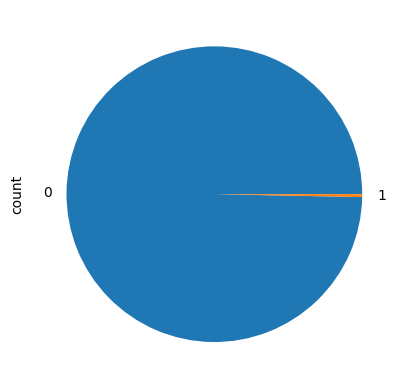

In [68]:
pred_tst["label"].value_counts().plot(kind="pie")

In [69]:
y_tst.value_counts()

label
0        610
1         37
Name: count, dtype: int64

In [70]:
pred_tst.label.value_counts()

label
0    645
1      2
Name: count, dtype: int64

In [71]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(1 * 2, 1)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_Simple_CNN, model_resnet)
for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(device)


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for ensemble: 0.025673145926234747
Epoch: 2 | Learning rate: [0.0003]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for ensemble: 0.02366851048894448
Epoch: 3 | Learning rate: [0.0003]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for ensemble: 0.022902101352073177
Epoch: 4 | Learning rate: [3.267e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for ensemble: 0.022561799882367107
Epoch: 5 | Learning rate: [9.9e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for ensemble: 0.02226888037996717
Epoch: 6 | Learning rate: [9.9e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

	| New lowest val loss for ensemble: 0.021631268452447238
Epoch: 7 | Learning rate: [1.0781099999999999e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 8 | Learning rate: [3.267e-05]


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

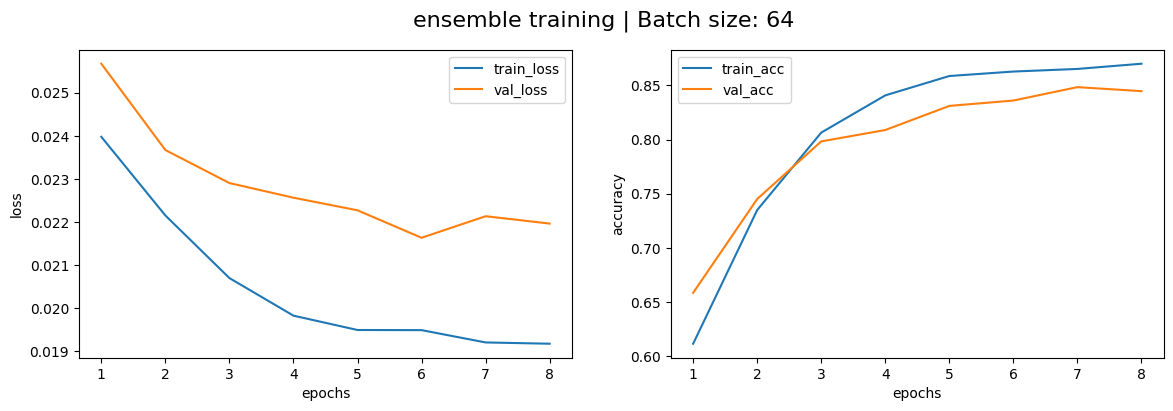


Training results:
	Min val loss 0.0216 was achieved during epoch #6
	Val accuracy during min val loss is 0.8360


In [72]:
ensemble_training_results = training(model=ensemble_model,
                                        model_name='ensemble',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_loader,
                                        val_dataloader=eval_loader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ensemble",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [73]:
torch.save(ensemble_model.state_dict(),"ensemble")

In [74]:
ids_all = []
predictions = []
labels= []
true_labels=[]
tst_acc_array = []
epoch_correct_items = 0
epoch_items = 0
# put the model in eval mode so we don't update any parameters
ensemble_model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(tst_loader, total=len(tst_loader)):
        ids=batch["image_id"]
        batch["image"]=batch["image"].to(device)
        batch["label"]=batch["label"].to(device)
        trues=batch["label"]
        # run the forward step
        y_pred = ensemble_model.forward(batch["image"])
        y_pred=F.sigmoid(y_pred)
        predictions.append(y_pred .float().cpu().numpy())
        labels.append((y_pred >= 0.5).float().cpu().numpy())
        true_labels.append(trues.float().cpu().numpy)
        preds = (y_pred>=0.5).float()
        correct_items = (preds == batch['label']).float().sum()
        epoch_correct_items += correct_items.item()
        epoch_items += len(batch['image'])
        for _id in ids:
          ids_all.append(_id.float().cpu().numpy())
    tst_acc_array.append(epoch_correct_items / epoch_items)
print("Done making predictions!")

  0%|          | 0/21 [00:00<?, ?it/s]

Done making predictions!


In [75]:
epoch_correct_items

544.0

In [76]:
tst_acc_array

[0.8408037094281299]

In [77]:
pred_tst = pd.DataFrame({
    "id": ids_all,
    "prediction": np.concatenate(predictions).reshape(-1,).astype("float"),
    "label": np.concatenate(labels).reshape(-1,).astype("int"),
}).set_index("id")

In [78]:
pred_tst.head()

,prediction,label
id,,
4705.0,0.346202,0
958.0,0.265053,0
5597.0,0.323880,0
5733.0,0.359303,0
1502.0,0.425540,0


<Axes: ylabel='count'>

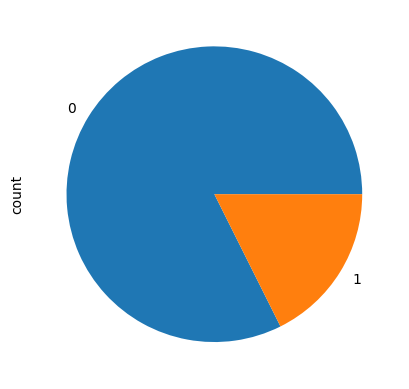

In [79]:
pred_tst["label"].value_counts().plot(kind="pie")

In [80]:
y_tst.value_counts()

label
0        610
1         37
Name: count, dtype: int64

In [81]:
pred_tst.label.value_counts()

label
0    533
1    114
Name: count, dtype: int64